In [0]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/detailed_probabilistic_robotics/'
sys.path.append(CURR_DIR)
sys.path.append(CURR_DIR + 'scripts/')

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

In [0]:
def make_ax():
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    return ax

def draw_observations(xs, z_list, ax):
    nearest_obs = {}
    for i in range(len(xs)):
        if i not in z_list:
            continue
        for obs_id, z in z_list[i]:
            x, y, theta = xs[i]
            distance, direction = z[0], z[1]
            mx = x + distance*math.cos(theta + direction)
            my = y + distance*math.sin(theta + direction)
            ax.plot([x,mx], [y,my], color='pink', alpha=0.5)

            if (nearest_obs.get(obs_id) == None) or (distance < nearest_obs[obs_id][0]):
                nearest_obs[obs_id] = (distance, x, y, mx, my)
                
    for key, val in nearest_obs.items():
        distance, x, y, mx, my = val
        ax.plot([x,mx], [y,my], color='green', alpha=0.5)

def draw_trajectory(xs, ax):
    poses = [xs[i] for i in range(len(xs))]
    ax.scatter([pose[0] for pose in poses], [pose[1] for pose in poses], s=7, marker='.', color='black')
    ax.plot([pose[0] for pose in poses], [pose[1] for pose in poses], linewidth=0.5, color='gray')

def draw_obs_edges(obs_edges, ax):
    for edge in obs_edges:
        x1_x = edge.x1[0]
        x1_y = edge.x1[1]
        x2_x = edge.x2[0]
        x2_y = edge.x2[1]
        ax.plot([x1_x, x2_x], [x1_y, x2_y], color='red', alpha=0.5)

def draw_landmarks(ms, ax):
    ax.scatter([ms[i][0] for i in ms], [ms[i][1] for i in ms], s=100, marker='*', color='blue', zorder=100)

def draw(xs, z_list, obs_edges=None, ms={}):
    ax = make_ax()
    draw_observations(xs, z_list, ax)
    draw_trajectory(xs, ax)
    if obs_edges is not None:
        draw_obs_edges(obs_edges, ax)
    draw_landmarks(ms, ax)
    plt.show()

In [0]:
def read_data(filepath):
    hat_xs = {}
    z_list = {}
    us = {}
    time_interval = 0.0

    with open(filepath) as f:
        for line in f.readlines():
            data = line.rstrip().split()
            step = int(data[1])

            if data[0] == 'time_interval:':
                time_interval = float(data[1])
                print('time_interval = ', time_interval)
            elif data[0] == 'u':
                nu = float(data[2])
                omega = float(data[2])
                us[step] = np.array([nu, omega])
            elif data[0] == 'x':
                x = float(data[2])
                y = float(data[3])
                theta = float(data[4])
                hat_xs[step] = np.array([x, y, theta])
            elif data[0] == 'z':
                if step not in z_list:
                    z_list[step] = []
                obs_id = int(data[2])
                distance = float(data[3])
                direction = float(data[4])
                orientation = float(data[5])
                # z = np.array([distance, direction, orientation]) ### 3D sensor (easier)
                z = np.array([distance, direction]) ### 2D sensor (harder)
                z_list[step].append((obs_id, z))
        
        return hat_xs, z_list, us, time_interval

In [0]:
def matM(nu, omega, time_interval, stds):
    return np.diag([
        stds['nn']**2*abs(nu)/time_interval + stds['no']**2*abs(omega)/time_interval,
        stds['on']**2*abs(nu)/time_interval + stds['oo']**2*abs(omega)/time_interval,
    ])

def matA(nu, omega, time_interval, theta):
    st, ct = math.sin(theta), math.cos(theta)
    stw, ctw = math.sin(theta + omega*time_interval), math.cos(theta + omega*time_interval)
    return np.array([
        [(stw - st)/omega,  -nu/(omega**2)*(stw - st) + nu/omega*time_interval*ctw],
        [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time_interval*stw],
        [0,                   time_interval]
    ])

def matF(nu, omega, time_interval, theta):
    F = np.diag([1.0, 1.0, 1.0])
    F[0, 2] = nu/omega*(math.cos(theta + omega*time_interval) - math.cos(theta))
    F[1, 2] = nu/omega*(math.sin(theta + omega*time_interval) - math.sin(theta))
    return F

In [0]:
def state_transition(prev_pose, nu, omega, dt):
    prev_theta = prev_pose[2]
    if math.fabs(omega) < 1.0e-10:
        delta_pose = np.array([
            nu*math.cos(prev_theta)*dt,
            nu*math.sin(prev_theta)*dt,
            omega*dt
        ])
    else:
        delta_pose = np.array([
            nu/omega*(math.sin(prev_theta + omega*dt) - math.sin(prev_theta)),
            nu/omega*(-math.cos(prev_theta + omega*dt) + math.cos(prev_theta)),
            omega * dt
        ])

    curr_pose = prev_pose + delta_pose
    return curr_pose

In [0]:
class MotionEdge:
    def __init__(
        self, t1, t2, xs, us, time_interval,
        motion_noise_stds={'nn':0.19, 'no':0.001, 'on':0.13, 'oo':0.2}
    ):
        self.t1, self.t2 = t1, t2
        self.hat_x1, self.hat_x2 = xs[t1], xs[t2]
        theta1 = self.hat_x1[2]

        nu2, omega2 = us[t2] # [m/s], [rad]
        if abs(omega2) < 1.0e-5:
            omega2 = 1.0e-5

        M = matM(nu2, omega2, time_interval, motion_noise_stds)
        A = matA(nu2, omega2, time_interval, theta1)
        F = matF(nu2, omega2, time_interval, theta1)

        Sigma = A.dot(M).dot(A.T) + 0.0001*np.eye(3) ### Covariance matrix
        Omega = np.linalg.inv(Sigma) ### Information matrix

        B1 = -F
        B2 = np.eye(3)

        self.matH_upper_left = B1.T.dot(Omega).dot(B1)
        self.matH_upper_right = B1.T.dot(Omega).dot(B2)
        self.matH_lower_left = B2.T.dot(Omega).dot(B1)
        self.matH_lower_right = B2.T.dot(Omega).dot(B2)
        
        constraint_x2 = state_transition(self.hat_x1, nu2, omega2, time_interval)
        hat_e = self.hat_x2 - constraint_x2
        while hat_e[2] < -math.pi:
            hat_e[2] += 2*math.pi
        while math.pi <= hat_e[2]:
            hat_e[2] -= 2*math.pi

        self.vecB_upper = B1.T.dot(Omega).dot(hat_e)
        self.vecB_lower = B2.T.dot(Omega).dot(hat_e)

In [0]:
class ObsEdge:
    def __init__(self, t1, t2, z1, z2, xs, sensor_std_rate=[0.14, 0.05]):
        assert z1[0] == z2[0] ### Make sure the obs IDs are same

        self.t1, self.t2 = t1, t2
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]

        distance1 = self.z1[0] # [m]
        direction1 = self.z1[1] # [rad]
        sin1 = math.sin(self.x1[2] + direction1)
        cos1 = math.cos(self.x1[2] + direction1)
        landmark_pose1 = np.array([
            self.x1[0] + distance1*cos1, # [m]
            self.x1[1] + distance1*sin1 # [m]
        ])

        distance2 = self.z2[0] # [m]
        direction2 = self.z2[1] # [rad]
        sin2 = math.sin(self.x2[2] + direction2)
        cos2 = math.cos(self.x2[2] + direction2)
        landmark_pose2 = np.array([
            self.x2[0] + distance2*cos2, # [m]
            self.x2[1] + distance2*sin2 # [m]
        ])
        
        hat_e = landmark_pose2 - landmark_pose1

        Q1 = np.diag([(distance1*sensor_std_rate[0])**2, sensor_std_rate[1]**2])
        R1 = -np.array([
            [cos1, -distance1*sin1],
            [sin1, distance1*cos1]
        ])

        Q2 = np.diag([(distance2*sensor_std_rate[0])**2, sensor_std_rate[1]**2])
        R2 = np.array([
            [cos2, -distance2*sin2],
            [sin2, distance2*cos2]
        ])

        ### 2D sensor (distance, direction)
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T) ### 2x2 Covariance matrix
        Omega = np.linalg.inv(Sigma) ### 2x2 Information matrix

        ### 2x3 Jacobian matrix of x1
        B1 = -np.array([
            [1, 0, -distance1*sin1],
            [0, 1, distance1*cos1]
        ])

        ### 2x3 Jacobian matrix of x2
        B2 = np.array([
            [1, 0, -distance2*sin2],
            [0, 1, distance2*cos2]
        ])

        self.matH_upper_left = B1.T.dot(Omega).dot(B1)
        self.matH_upper_right = B1.T.dot(Omega).dot(B2)
        self.matH_lower_left = B2.T.dot(Omega).dot(B1)
        self.matH_lower_right = B2.T.dot(Omega).dot(B2)

        self.vecB_upper = B1.T.dot(Omega).dot(hat_e)
        self.vecB_lower = B2.T.dot(Omega).dot(hat_e)

In [0]:
def make_obs_edges(hat_xs, z_list):
    landmark_keys_z_list = {}

    for step in z_list:
        for obs in z_list[step]:
            landmark_id = obs[0]
            if landmark_id not in landmark_keys_z_list:
                landmark_keys_z_list[landmark_id] = []
            landmark_keys_z_list[landmark_id].append((step, obs))
    
    edges = []
    for landmark_id in landmark_keys_z_list:
        step_pairs = list(itertools.combinations(landmark_keys_z_list[landmark_id], 2))
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]

    return edges, landmark_keys_z_list

In [0]:
def add_edge(edge, matH, vecB, robot_domain_dim):
    f1 = robot_domain_dim*edge.t1
    t1 = f1 + robot_domain_dim
    
    f2 = robot_domain_dim*edge.t2
    t2 = f2 + robot_domain_dim

    matH[f1:t1, f1:t1] += edge.matH_upper_left
    matH[f1:t1, f2:t2] += edge.matH_upper_right
    matH[f2:t2, f1:t1] += edge.matH_lower_left
    matH[f2:t2, f2:t2] += edge.matH_lower_right

    vecB[f1:t1] += edge.vecB_upper
    vecB[f2:t2] += edge.vecB_lower

time_interval =  3.0


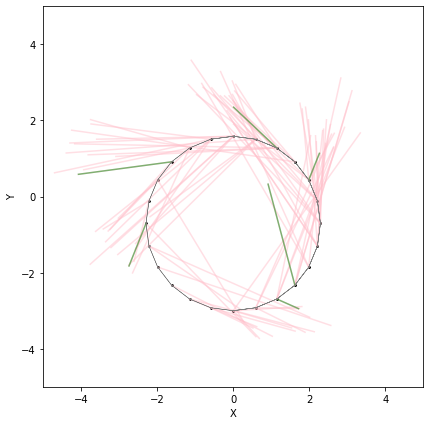

1-th: diff = 6.030247729692313
2-th: diff = 0.6355044659359033
3-th: diff = 0.8682545624084569
4-th: diff = 0.08278401912394466
5-th: diff = 0.4119266352073105
6-th: diff = 0.10754872335228029
7-th: diff = 0.22838070612721056
8-th: diff = 0.12218825482811647
9-th: diff = 0.14603562384258398
10-th: diff = 0.10346644912520646
11-th: diff = 0.10109338790112517
12-th: diff = 0.08025504817139575
13-th: diff = 0.07249659638328237
14-th: diff = 0.06023196686323489
15-th: diff = 0.05270637770356518
16-th: diff = 0.04457701246353886
17-th: diff = 0.03849117002838767
18-th: diff = 0.0327726962018099
19-th: diff = 0.0281323841214334
20-th: diff = 0.024005881572446194
21-th: diff = 0.02054749139888188
22-th: diff = 0.01754020118351509
23-th: diff = 0.014987501274669827
24-th: diff = 0.012788379569897607
25-th: diff = 0.01091251230414772
26-th: diff = 0.00930292140288311


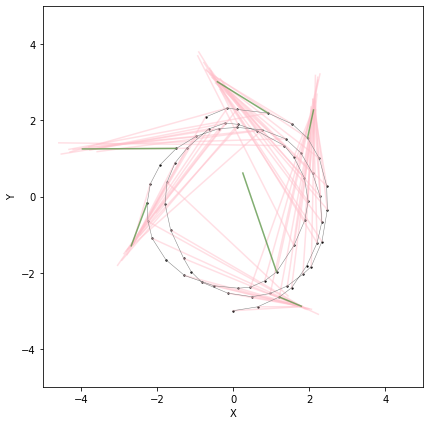

In [0]:
file_path = CURR_DIR + 'sensor_data/graph_slam_log.txt'
hat_xs, z_list, us, time_interval = read_data(file_path)
draw(hat_xs, z_list, None)

robot_domain_dim = 3 ### x, y, theta
traj_dim = robot_domain_dim*len(hat_xs)

for itr in range(1, 1000):
    edges, _ = make_obs_edges(hat_xs, z_list)
    for i in range(len(hat_xs) - 1):
        edges.append(MotionEdge(i, i+1, hat_xs, us, time_interval))

    matH = np.zeros((traj_dim, traj_dim))
    matH[0:robot_domain_dim, 0:robot_domain_dim] += np.eye(robot_domain_dim)*1.0e+6
    vecB = np.zeros(traj_dim)
    for edge in edges:
        add_edge(edge, matH, vecB, robot_domain_dim)

    delta_xs = -np.linalg.inv(matH).dot(vecB)
    for i in range(len(hat_xs)):
        hat_xs[i] += delta_xs[robot_domain_dim*i : robot_domain_dim*(i+1)]

    diff = np.linalg.norm(delta_xs)
    print('{}-th: diff = {}'.format(itr, diff))
    if diff < 0.01:
        draw(hat_xs, z_list, None)
        break

In [0]:
class MapEdge:
    def __init__(self, step, z, head_step, head_z, xs, sensor_std_rate=[0.14, 0.05]):
        self.x = xs[step]
        self.z = z

        theta = self.x[2]
        head_theta = xs[head_step][2]

        distance = self.z[0] # [m]
        direction = self.z[1] # [rad]
        head_direction = head_z[1] # [rad]

        sin = math.sin(theta + direction)
        cos = math.cos(theta + direction)

        self.m = np.array([
            self.x[0] + distance*cos,
            self.x[1] + distance*sin
        ])

        Q = np.diag([(distance*sensor_std_rate[0])**2, sensor_std_rate[1]**2])
        R = -np.array([
            [cos, -distance*sin],
            [sin, distance*cos]
        ])

        ### 2D sensor (distance, direction)
        self.Sigma = R.dot(Q).dot(R.T) ### 2x2 Covariance matrix
        self.Omega = np.linalg.inv(self.Sigma) ### 2x2 Information matrix

        self.xi = self.Omega.dot(self.m)

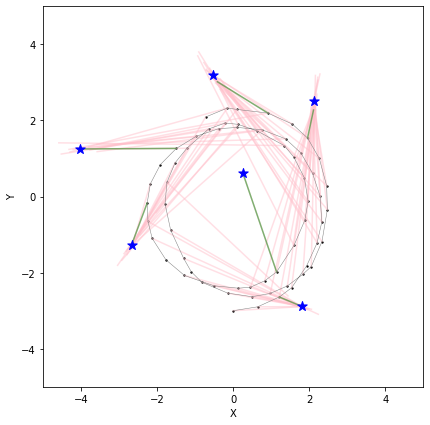

In [0]:
_, landmark_keys_z_list = make_obs_edges(hat_xs, z_list)
ms = {}

for landmark_id in landmark_keys_z_list:
    map_edges = []
    head_step, head_obs = landmark_keys_z_list[landmark_id][0]
    for step, obs in landmark_keys_z_list[landmark_id]:
        z = obs[1]
        head_z = head_obs[1]
        map_edges.append(MapEdge(step, z, head_step, head_z, hat_xs))

    ### Just averaging the estimated landmark positions
    ms[landmark_id] = np.mean([edge.m for edge in map_edges], axis=0)

draw(hat_xs, z_list, None, ms)

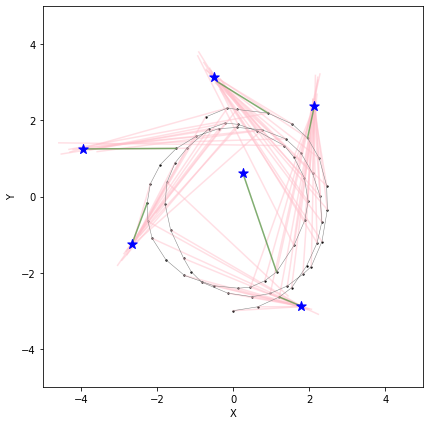

In [0]:
_, landmark_keys_z_list = make_obs_edges(hat_xs, z_list)
ms = {}

for landmark_id in landmark_keys_z_list:
    map_edges = []
    head_step, head_obs = landmark_keys_z_list[landmark_id][0]
    for step, obs in landmark_keys_z_list[landmark_id]:
        z = obs[1]
        head_z = head_obs[1]
        map_edges.append(MapEdge(step, z, head_step, head_z, hat_xs))

    ### Linear Least Square (weighted by the inverse of covariance matrix) 
    Omega = np.zeros((2, 2))
    xi = np.zeros(2)
    for edge in map_edges:
        Omega += edge.Omega
        xi += edge.xi
    ms[landmark_id] = np.linalg.inv(Omega).dot(xi)

draw(hat_xs, z_list, None, ms)